In [1]:
from google.colab import files
uploaded = files.upload()

Saving naujas_gnm.xlsx to naujas_gnm (3).xlsx


In [2]:
import pandas as pd
df = pd.read_excel("naujas_gnm.xlsx")

In [3]:

from sqlalchemy import create_engine
import re

In [4]:

df = df.rename(columns={
    "Siptomas": "simptomas",
    "Input/situacija": "ivestis",
    "Output/GNM_interpretacija": "isvestis"
})

def normalizuoti_teksta(tekstas):
    if pd.isna(tekstas):
        return ""
    tekstas = str(tekstas).strip()
    if tekstas.startswith('"') and tekstas.endswith('"'):
        tekstas = tekstas[1:-1]
    tekstas = tekstas.replace("“", '"').replace("”", '"').replace("„", '"')
    tekstas = tekstas.replace("‘", "'").replace("’", "'")
    tekstas = tekstas.replace("–", "-").replace("—", "-")
    tekstas = tekstas.replace("\\", "/")

    if tekstas.startswith('"'):
        tekstas = tekstas[1:]
    if tekstas.endswith('"'):
        tekstas = tekstas[:-1]

    tekstas = re.sub(r"[\r\n\t]", " ", tekstas)
    tekstas = re.sub(r"\s{2,}", " ", tekstas)
    tekstas = re.sub(r"\s+([.,;!?()])", r"\1", tekstas)
    return tekstas

df["simptomas"] = df["simptomas"].apply(lambda x: normalizuoti_teksta(x).lower())
df["ivestis"] = df["ivestis"].apply(lambda x: normalizuoti_teksta(x).lower())
df["isvestis"] = df["isvestis"].apply(normalizuoti_teksta)

df["ivestis"] = "simptomas: " + df["simptomas"] + ". " + df["ivestis"]

In [5]:
!pip install numpy==1.26.4 datasets==2.18.0 transformers sentencepiece

In [6]:
!pip install openpyxl pymysql sqlalchemy

In [7]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

Tokenizavimo funkcija

In [8]:
from transformers import T5Tokenizer, TFAutoModelForSeq2SeqLM
import tensorflow as tf

model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [9]:
def tokenize_function(example):
    input_enc = tokenizer(example["ivestis"], padding="max_length", truncation=True, max_length=128)
    output_enc = tokenizer(example["isvestis"], padding="max_length", truncation=True, max_length=128)
    input_enc["labels"] = output_enc["input_ids"]
    return input_enc

train_tokenized = train_dataset.map(tokenize_function)
test_tokenized = test_dataset.map(tokenize_function)


Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

TF dataset paruošimas

In [10]:
train_set = train_tokenized.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["labels"],
    shuffle=True,
    batch_size=8,
)

val_set = test_tokenized.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["labels"],
    shuffle=False,
    batch_size=8,
)


/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py:401: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


 Modelio treniravimas

In [11]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5))
history = model.fit(train_set, validation_data=val_set, epochs=100)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/100
49/49 [==============================] - 57s 353ms/step - loss: 4.6640 - val_loss: 3.9300
Epoch 2/100
49/49 [==============================] - 10s 213ms/step - loss: 4.0590 - val_loss: 3.6625
Epoch 3/100
49/49 [==============================] - 9s 176ms/step - loss: 3.8192 - val_loss: 3.4293
Epoch 4/100
49/49 [==============================] - 8s 172ms/step - loss: 3.5741 - val_loss: 3.2506
Epoch 5/100
49/49 [==============================] - 9s 176ms/step - loss: 3.3943 - val_loss: 3.1096
Epoch 6/100
49/49 [==============================] - 9s 186ms/step - loss: 3.2508 - val_loss: 2.9885
Epoch 7/100
49/49 [==============================] - 10s 203ms/step - loss: 3.1179 - val_loss: 2.8883
Epoch 8/100
49/49 [==============================] - 9s 187ms/step - loss: 3.0170 - val_loss: 2.8017
Epoch 9/100
49/49 [==============================] - 9s 191ms/step - loss: 2.9440 - val_loss: 2.7250
Epoch 10/100
49/49 [==============================] - 9s 189ms/step - loss: 2.8622 - val

 8. Modelio testavimas

In [12]:
model.save_pretrained("gnm-t5-final")
tokenizer.save_pretrained("gnm-t5-final")

('gnm-t5-final/tokenizer_config.json',
 'gnm-t5-final/special_tokens_map.json',
 'gnm-t5-final/spiece.model',
 'gnm-t5-final/added_tokens.json')

In [13]:
def test_ivestis(ivestis):
    input_ids = tokenizer(ivestis, return_tensors="tf", truncation=True, padding=True).input_ids
    output_ids = model.generate(
        input_ids,
        max_length=128,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        top_p=0.95,
        repetition_penalty=2.5,
        eos_token_id=tokenizer.eos_token_id,
        decoder_start_token_id=tokenizer.pad_token_id
    )
    isvestis = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"🔹 Įvestis: {ivestis}")
    print(f"🧠 Sugeneruota išvestis: {isvestis}")
    return isvestis

test_ivestis("insultas. žmogų ištiko insultas po skyrybų.")

🔹 Įvestis: insultas. žmogų ištiko insultas po skyrybų.
🧠 Sugeneruota išvestis: Pagal GNM, insultas mogus atskyrimo konfliktais. Krypties gali sukelninybene amorti pasireiktuliu ar niekyrku nuvertinimumami? Danai susij su bejeikianam umakina


'Pagal GNM, insultas mogus atskyrimo konfliktais. Krypties gali sukelninybene amorti pasireiktuliu ar niekyrku nuvertinimumami? Danai susij su bejeikianam umakina'

In [14]:
from google.colab import files
import shutil

# Suspaudžiam aplanką į zip, kad būtų galima atsisiųsti
shutil.make_archive("gnm-t5-final", 'zip', "gnm-t5-final")

# Atsisiunčiam
files.download("gnm-t5-final.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
!pip install rouge_score sacrebleu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.7 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=206a53b01e1a6583b45cdb08dd6b395f70e3c86b80d83d88ff4c7c85fa8ee44b
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [23]:
from datasets import load_metric

# Įkeliamos metrikos (vienkartinis veiksmas)
rouge = load_metric("rouge")
bleu = load_metric("sacrebleu")

# Naudojama mažesnė test rinkinio dalis
input_texts = test_df["ivestis"].tolist()
target_texts = test_df["isvestis"].tolist()

sample_input = input_texts[:5]
sample_target = target_texts[:5]

# Modelio prognozės
predictions = []
for text in sample_input:
    input_ids = tokenizer(text, return_tensors="tf", truncation=True, padding=True).input_ids
    output_ids = model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)
    pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    predictions.append(pred)

# Metrikų skaičiavimas
rouge_result = rouge.compute(predictions=predictions, references=sample_target)
bleu_result = bleu.compute(predictions=predictions, references=[[r] for r in sample_target])

# Tik santrauka
print("🔹 ROUGE-L F1:", round(rouge_result["rougeL"].mid.fmeasure, 3))
print("🔹 BLEU Score:", round(bleu_result["score"], 3))

/usr/local/lib/python3.11/dist-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/datasets/load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from t

🔹 ROUGE-L F1: 0.175
🔹 BLEU Score: 6.317


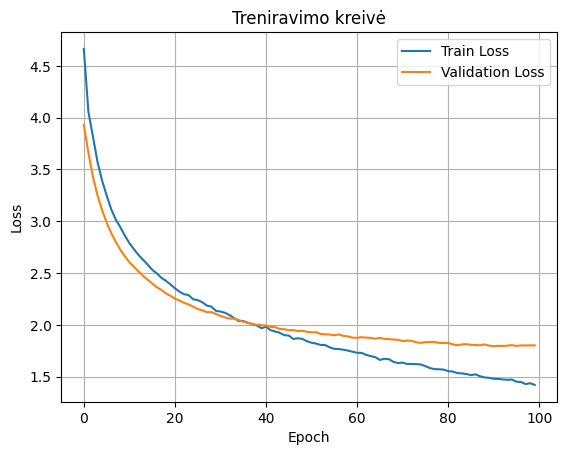

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Treniravimo kreivė")
plt.legend()
plt.grid(True)
plt.show()